# Sentiment Analysis with Deep Learning using BERT

### Project Outline

**Task 1**: Loading the Data

**Task 2**: Loading Tokenizer and Encoding our Data

**Task 3**: Setting up BERT Pretrained Model

**Task 4**: Creating Data Loaders

**Task 5**: Setting Up Optimizer and Scheduler

**Task 6**: Defining our Performance Metrics

**Task 7**: Creating our Training Loop

## Loading the Data


In [ ]:
from google.colab import drive
import pandas as pd
from pandas import DataFrame

In [ ]:
drive.mount('/content/drive')  # asks for authentication
train_df = pd.read_csv("/content/drive/My Drive/Independent Work/train.csv")
validation_df = pd.read_csv("/content/drive/My Drive/Independent Work/validation.csv")
test_df = pd.read_csv("/content/drive/My Drive/Independent Work/test.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df["document"][0]

"As talk-shows go, Larry King Live is not bad, and since he occasionally gets good guests, it's a show to turn on once in awhile, but not compulsively. When Bill Maher, Carl Bernstein, a former president, or other substantive guests sit across from him, it's not too bad. Other times, he tends to host guests involved in the latest celebrity scandal which contributes absolutely no intelligent information to the country and feeds a largely uneducated public that wants to hear the latest gossip about movie and TV stars. During the OJ Simpson trial, it seemed like every other guest on his show was related to the case. But is this really journalism? Or the National Enquirer on the tube? Sometimes, it comes off a little bit like trash television--Jerry Springer in a sit down interview with phone calls instead of a live audience.On the other side, King's show is definitely much better than Bill O'Reilly whose show is nothing more than a rightest-political platform of the Rush Limbaugh variety.

In [ ]:
validation_df

,Unnamed: 0,document,sentiment
0,0,Don't quite know why some people complain abou...,1
1,1,"The Kite Runner was beautiful, poignant and ve...",1
2,2,I absolutely loved this movie! It's my number ...,1
3,3,I could not watch more than 10 minutes of this...,0
4,4,This movie doesn't even deserve a 1/10 This mo...,0
...,...,...,...
4995,4995,"""Crimes of Passion"" is a film that is disappoi...",0
4996,4996,Not only unique for its time but one of the gr...,1
4997,4997,"This was an interesting movie...half-comedy, h...",1
4998,4998,I LOVE Sandra Bullock-She's one of my all-time...,0


In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


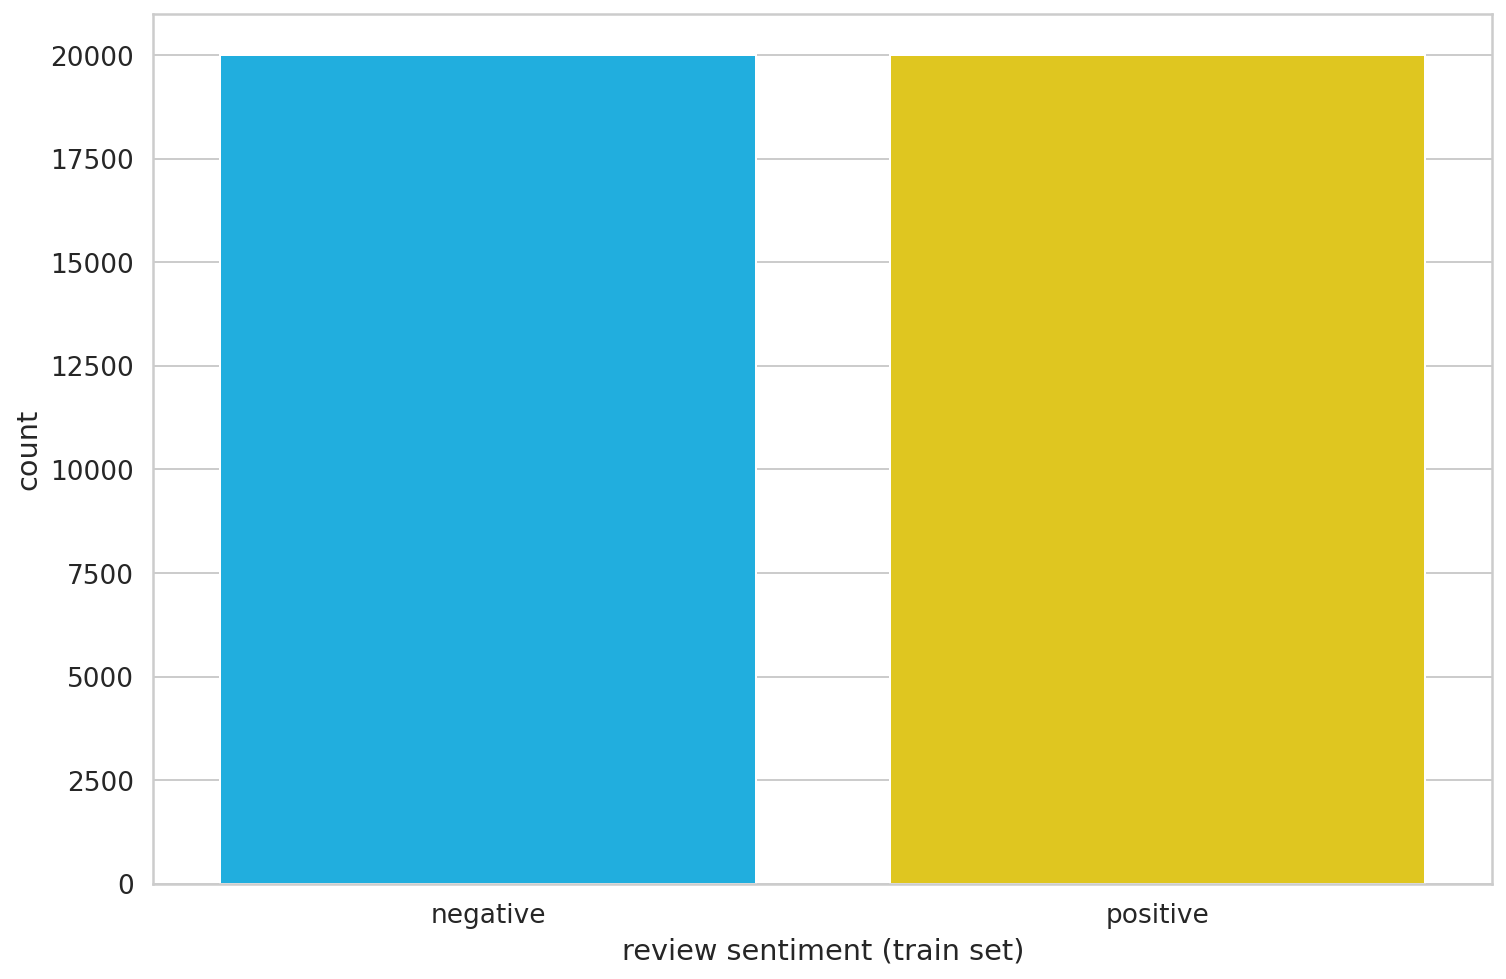

In [ ]:
class_names = ['negative','positive']
ax = sns.countplot(train_df["sentiment"])
plt.xlabel('review sentiment (train set)');
ax.set_xticklabels(class_names);


In [ ]:
# Next, I will choose the dataset size

train_text, train_sentiment = train_df["document"], train_df["sentiment"]
validation_text, validation_sentiment = validation_df["document"], validation_df["sentiment"]
test_text, test_sentiment = test_df["document"], test_df["sentiment"]

In [ ]:
train_text


0        As talk-shows go, Larry King Live is not bad, ...
1        This movie was made on a relatively small budg...
2        I had the misfortune to sit through the full 1...
3        This movie is the very worst that I have ever ...
4        I would never have thought I would almost cry ...
                               ...                        
39995    I must, in light of the encomia of praise for ...
39996    Here we have a miniseries, which revels in in ...
39997    James J. Corbett's autobiography "The Roar of ...
39998    I've had a thing for this Kari chick for a whi...
39999    Sorry, but aside from Kim Basinger doing a goo...
Name: document, Length: 40000, dtype: object

## Loading Tokenizer and Encoding our Data

In [ ]:
!pip install transformers
from transformers import BertTokenizer

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, 
                                          do_lower_case=True)

In [ ]:
import numpy as np

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
from sklearn.preprocessing import LabelEncoder


class ChunkedDataset(Dataset):

    def __init__(self, text, sentiment, chunk_len=512, overlap_len=50, min_len=1):
        self.chunk_len = chunk_len
        self.overlap_len = overlap_len
        self.min_len = min_len
        self.data = text
        self.label = sentiment
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

    def long_terms_tokenizer(self, data_tokenize, targets):

        long_terms_token = []
        input_ids_list = []
        attention_mask_list = []
        token_type_ids_list = []
        targets_list = []

        previous_input_ids = data_tokenize["input_ids"].reshape(-1)
        previous_attention_mask = data_tokenize["attention_mask"].reshape(-1)
        previous_token_type_ids = data_tokenize["token_type_ids"].reshape(-1)
        remain = data_tokenize.get("overflowing_tokens").reshape(-1)
        remain = torch.flip(remain, [-1])
        targets = torch.tensor(targets, dtype=torch.int)

        input_ids_list.append(previous_input_ids)
        attention_mask_list.append(previous_attention_mask)
        token_type_ids_list.append(previous_token_type_ids)
        targets_list.append(targets)

        if not remain == None:
            remain = torch.tensor(remain, dtype=torch.long)
            idxs = range(len(remain)+self.chunk_len)
            idxs = idxs[(self.chunk_len-self.overlap_len-2)
                         ::(self.chunk_len-self.overlap_len-2)]
            input_ids_first_overlap = previous_input_ids[-(
                self.overlap_len+1):-1]
            start_token = torch.tensor([101], dtype=torch.long)
            end_token = torch.tensor([102], dtype=torch.long)

            for i, idx in enumerate(idxs):
                if i == 0:
                    input_ids = torch.cat(
                        (input_ids_first_overlap, remain[:idx]))
                elif i == len(idxs):
                    input_ids = remain[idx:]
                elif previous_idx >= len(remain):
                    break
                else:
                    input_ids = remain[(previous_idx-self.overlap_len):idx]

                previous_idx = idx

                nb_token = len(input_ids)+2
                attention_mask = torch.ones(self.chunk_len, dtype=torch.long)
                attention_mask[nb_token:self.chunk_len] = 0
                token_type_ids = torch.zeros(self.chunk_len, dtype=torch.long)
                input_ids = torch.cat((start_token, input_ids, end_token))
                if self.chunk_len-nb_token > 0:
                    padding = torch.zeros(
                        self.chunk_len-nb_token, dtype=torch.long)
                    input_ids = torch.cat((input_ids, padding))

                input_ids_list.append(input_ids)
                attention_mask_list.append(attention_mask)
                token_type_ids_list.append(token_type_ids)
                targets_list.append(targets)

        return({
            'ids': input_ids_list,  # torch.tensor(ids, dtype=torch.long),
            # torch.tensor(mask, dtype=torch.long),
            'mask': attention_mask_list,
            # torch.tensor(token_type_ids, dtype=torch.long),
            'token_type_ids': token_type_ids_list,
            'targets': targets_list,
            'length_data': [torch.tensor(len(targets_list), dtype=torch.long)]
        })


    def __getitem__(self, idx):
        """  Return a single tokenized sample at a given positon [idx] from data"""

        text = self.data[idx]
        targets = int(self.label[idx])
        data = self.tokenizer.encode_plus(
            text,
            padding='max_length', 
            max_length=self.chunk_len,
            add_special_tokens=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_overflowing_tokens=True,
            truncation = True,
            return_tensors='pt')

        long_token = self.long_terms_tokenizer(data, targets)
        return long_token

    def __len__(self):
        """ Return data length """
        return len(self.label)

In [ ]:
texts = ["Hello, it is is nice to meet you.", "In this notebook, we explore different approaches to overcome on the main limitation."]
sentiments = [1,0]

dataset1 = ChunkedDataset(texts, sentiments, chunk_len=7, overlap_len=2, min_len=1)

In [ ]:
chunks = (dataset1.__getitem__(1))
chunks

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'ids': [tensor([  101,  1999,  2023, 14960,  1010,  2057,   102]),
  tensor([ 101, 1010, 2057, 8849, 2367, 8107,  102]),
  tensor([ 101, 2367, 8107, 2000, 9462, 2006,  102]),
  tensor([  101,  9462,  2006,  1996,  2364, 22718,   102]),
  tensor([  101,  2364, 22718,  1012,   102,     0,     0])],
 'length_data': [tensor(5)],
 'mask': [tensor([1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 0, 0])],
 'targets': [tensor(0, dtype=torch.int32),
  tensor(0, dtype=torch.int32),
  tensor(0, dtype=torch.int32),
  tensor(0, dtype=torch.int32),
  tensor(0, dtype=torch.int32)],
 'token_type_ids': [tensor([0, 0, 0, 0, 0, 0, 0]),
  tensor([0, 0, 0, 0, 0, 0, 0]),
  tensor([0, 0, 0, 0, 0, 0, 0]),
  tensor([0, 0, 0, 0, 0, 0, 0]),
  tensor([0, 0, 0, 0, 0, 0, 0])]}

In [ ]:
print(texts[1])
for c in chunks['ids']:
  print(c)
  print(tokenizer.convert_ids_to_tokens(c))

In this notebook, we explore different approaches to overcome on the main limitation.
tensor([  101,  1999,  2023, 14960,  1010,  2057,   102])
['[CLS]', 'in', 'this', 'notebook', ',', 'we', '[SEP]']
tensor([ 101, 1010, 2057, 8849, 2367, 8107,  102])
['[CLS]', ',', 'we', 'explore', 'different', 'approaches', '[SEP]']
tensor([ 101, 2367, 8107, 2000, 9462, 2006,  102])
['[CLS]', 'different', 'approaches', 'to', 'overcome', 'on', '[SEP]']
tensor([  101,  9462,  2006,  1996,  2364, 22718,   102])
['[CLS]', 'overcome', 'on', 'the', 'main', 'limitation', '[SEP]']
tensor([  101,  2364, 22718,  1012,   102,     0,     0])
['[CLS]', 'main', 'limitation', '.', '[SEP]', '[PAD]', '[PAD]']


In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Get some data on the lenghts of sentence in the dataset
dict_sent = {}
dict_words = {}
list_sent = []
list_words = []

for t in train_text:
  sent_tokens = nltk.sent_tokenize(t)
  i = len(sent_tokens)
  list_sent.append(i)
  for sent_token in sent_tokens:
    word_tokens = nltk.word_tokenize(sent_token)
    j = len(word_tokens)
    list_words.append(j)
    if j in dict_words:
      dict_words[j] += 1
    else:
      dict_words[j] = 1

  if i in dict_sent:
    dict_sent[i] += 1
  else:
    dict_sent[i] = 1


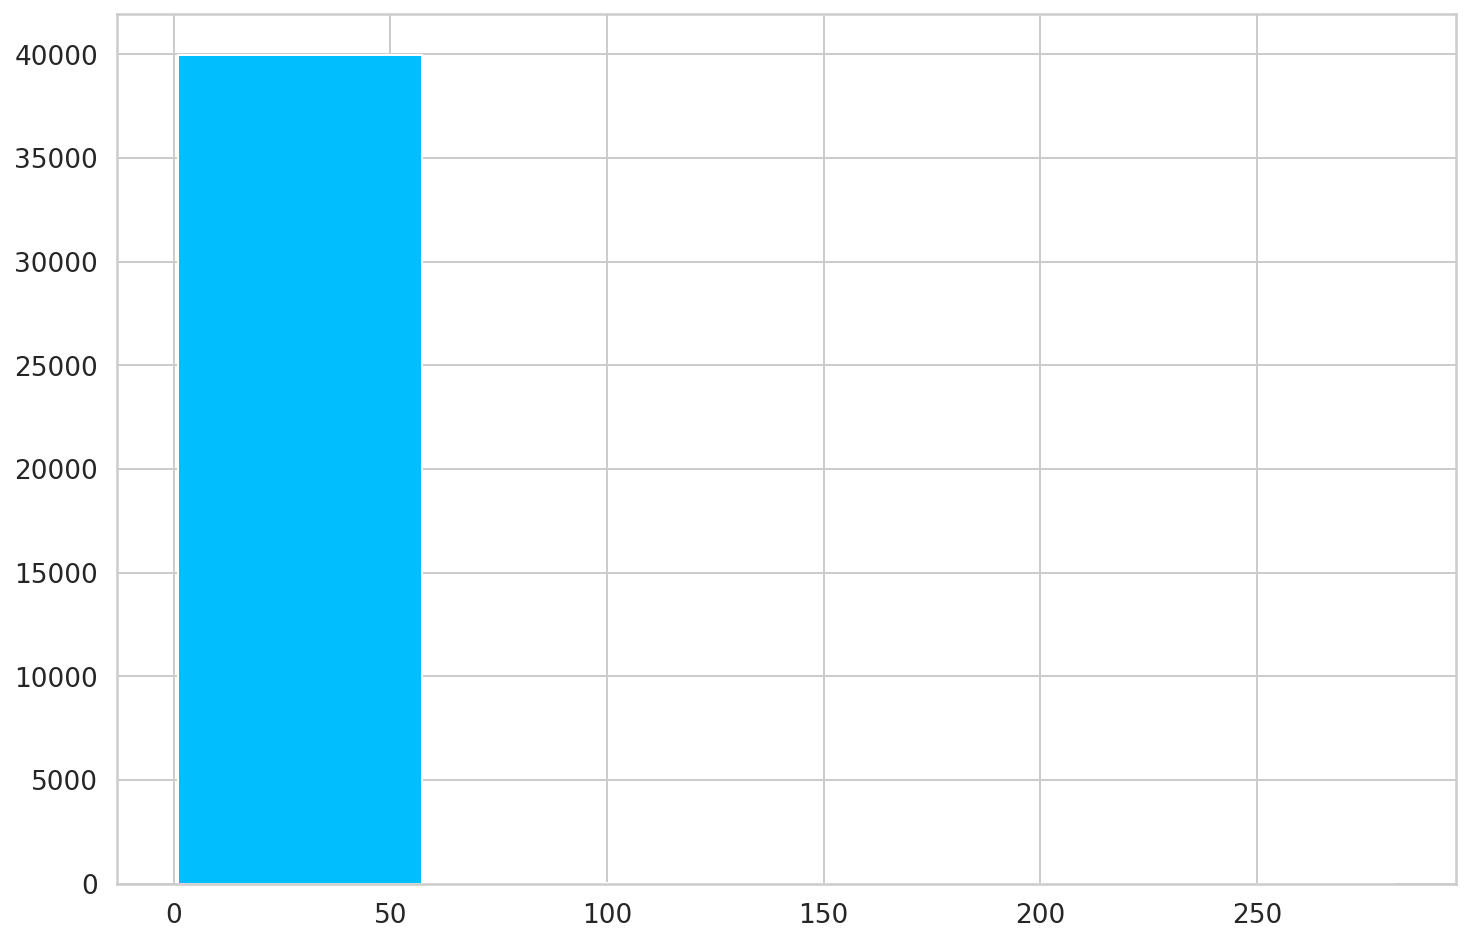

In [ ]:
pd.Series(list_sent).hist(bins = 5)

In [ ]:
np.mean(list_sent)

10.78165

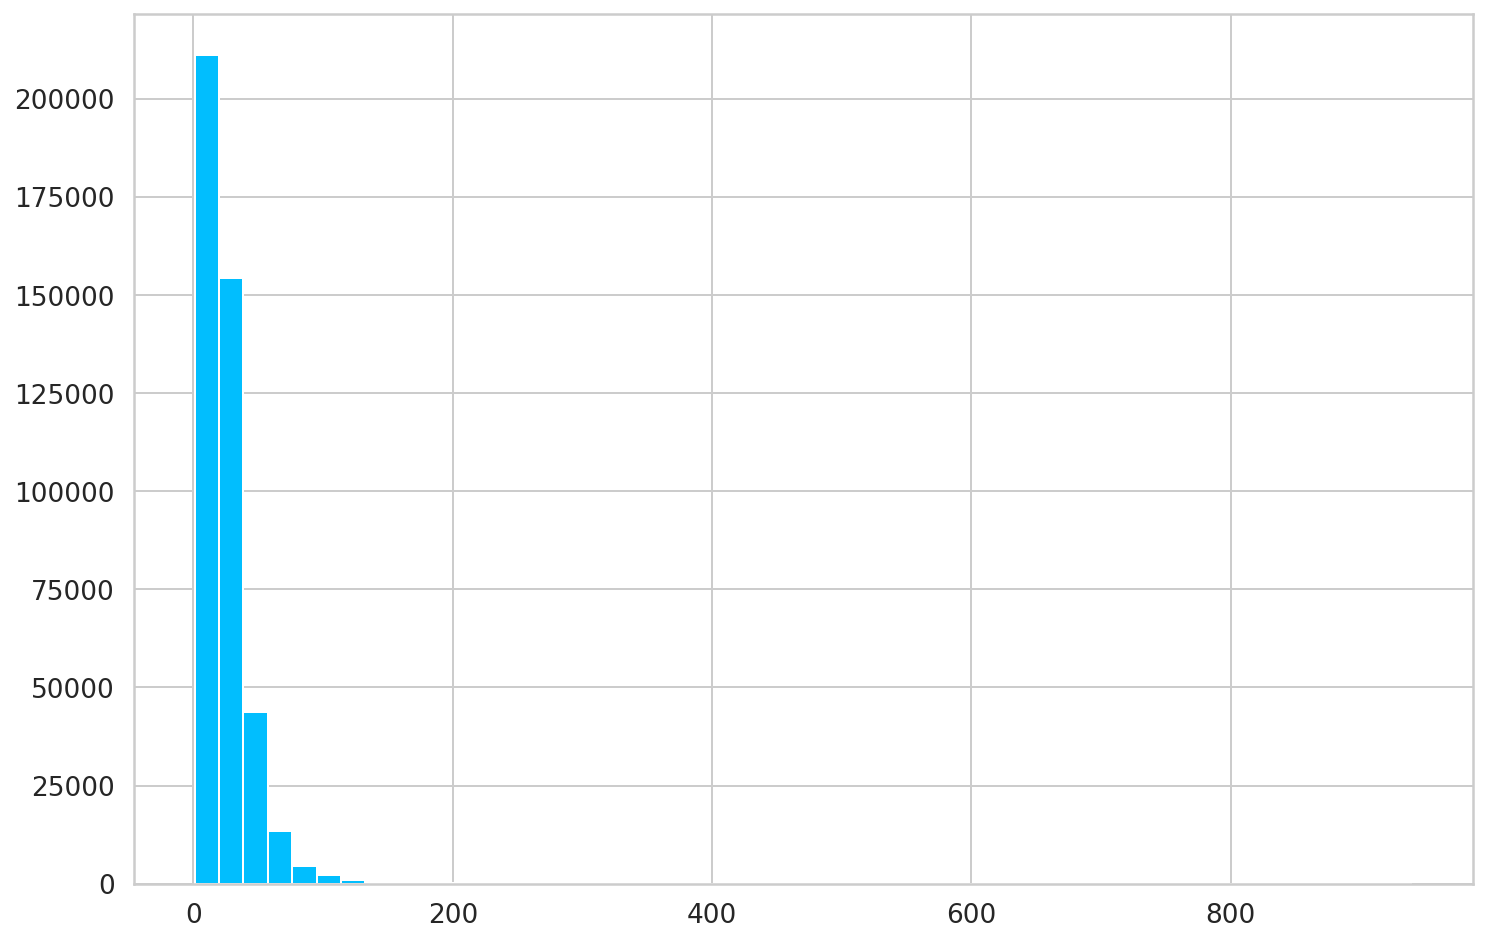

In [ ]:
pd.Series(list_words).hist(bins = 50)

In [ ]:
np.mean(list_words)

24.28797772140628

In [ ]:
# Set max_seq_len by picking the 80th percentile in the sorted list of sequence lenghts
chunk_len_index = np.round((len(list_words) * 3) // 4) - 1
chunk_len = np.sort(list_words)[chunk_len_index]
chunk_len

31

In [ ]:
# Set up the dataset parameters
chunk_len = chunk_len
overlap_len = 5
min_len = 1

In [ ]:
dataset_train = ChunkedDataset(train_text, train_sentiment.tolist(), chunk_len=chunk_len, overlap_len=overlap_len, min_len=min_len)
dataset_val = ChunkedDataset( validation_text, validation_sentiment.tolist(), chunk_len=chunk_len, overlap_len=overlap_len, min_len=min_len)
dataset_test = ChunkedDataset(test_text, test_sentiment.tolist(), chunk_len=chunk_len, overlap_len=overlap_len, min_len=min_len)

In [ ]:
len(dataset_train)

40000

In [ ]:
len(dataset_val)

5000

## Creating Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
def collate_function(batches):
    return [{key: torch.stack(value) for key, value in batch.items()} for batch in batches]

In [ ]:
batch_size = 12

dataloader_train = DataLoader(dataset_train, 
                              num_workers = 4,
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size,
                              collate_fn=collate_function)

dataloader_validation = DataLoader(dataset_val, 
                                   num_workers = 4,
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size,
                                   collate_fn=collate_function)

dataloader_test = DataLoader(dataset_test, 
                             num_workers = 4,
                             sampler=SequentialSampler(dataset_test), 
                             batch_size=batch_size,
                             collate_fn=collate_function)

## Setting Up The Model

In [ ]:
import torch.nn as nn

In [ ]:
class LSTM_over_BERT(nn.Module):
    """ Make an LSTM model over a fine tuned bert model.
    Parameters
    __________
    bertFineTuned: BertModel
        A bert fine tuned instance
    """

    def __init__(self, bertFineTuned):
        super(LSTM_over_BERT, self).__init__()
        self.bertFineTuned = bertFineTuned
        self.lstm = nn.LSTM(768, 100, num_layers=1, bidirectional=False)
        self.out = nn.Linear(100, 2)

    def forward(self, ids, mask, token_type_ids, length):
        """ Define how to performed each call
        Parameters
        __________
        ids: array
            -
        mask: array
            - 
        token_type_ids: array
            -
        length: int
            -
        Returns:
        _______
        -
        """
        pooled_out = self.bertFineTuned(
            input_ids=ids, attention_mask=mask)[1]
        chunks_emb = pooled_out.split_with_sizes(length)

        seq_lengths = torch.LongTensor([x for x in map(len, chunks_emb)])

        batch_emb_pad = nn.utils.rnn.pad_sequence(
            chunks_emb, padding_value=-91, batch_first=True)
        batch_emb = batch_emb_pad.transpose(0, 1)  # (B,L,D) -> (L,B,D)
        lstm_input = nn.utils.rnn.pack_padded_sequence(
            batch_emb, seq_lengths.cpu().numpy(), batch_first=False, enforce_sorted=False)

        packed_output, (h_t, h_c) = self.lstm(lstm_input, )  # (h_t, h_c))
#         output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, padding_value=-91)

        h_t = h_t.view(-1, 100)

        return self.out(h_t)

In [ ]:
from transformers import BertForSequenceClassification
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load fine-tuned BERT Base model (epoch 10)
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
fine_tuned_bert_base_model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME,
                                                      num_labels=2,
                                                      output_attentions=True,
                                                      output_hidden_states=True)
fine_tuned_bert_base_model.load_state_dict(torch.load('/content/drive/My Drive/Independent Work/bert_base_epoch_10.model'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [ ]:
list(fine_tuned_bert_base_model.children())[0]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
model = LSTM_over_BERT(bertFineTuned=list(fine_tuned_bert_base_model.children())[0]).to(device)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== LSTM ====\n')

for p in params[-6:-2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 205 different named parameters.

==== Embedding Layer ====

bertFineTuned.embeddings.word_embeddings.weight         (30522, 768)
bertFineTuned.embeddings.position_embeddings.weight       (512, 768)
bertFineTuned.embeddings.token_type_embeddings.weight       (2, 768)
bertFineTuned.embeddings.LayerNorm.weight                     (768,)
bertFineTuned.embeddings.LayerNorm.bias                       (768,)

==== First Transformer ====

bertFineTuned.encoder.layer.0.attention.self.query.weight   (768, 768)
bertFineTuned.encoder.layer.0.attention.self.query.bias       (768,)
bertFineTuned.encoder.layer.0.attention.self.key.weight   (768, 768)
bertFineTuned.encoder.layer.0.attention.self.key.bias         (768,)
bertFineTuned.encoder.layer.0.attention.self.value.weight   (768, 768)
bertFineTuned.encoder.layer.0.attention.self.value.bias       (768,)
bertFineTuned.encoder.layer.0.attention.output.dense.weight   (768, 768)
bertFineTuned.encoder.layer.0.attention.output.dense.bi

## Setting Up Optimiser and Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=3e-5,
                  correct_bias=False)

In [ ]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def f1_score_func(preds, labels):
    return f1_score(labels, np.argmax(preds, axis=1), average='weighted')

In [ ]:
def loss_function(outputs, targets):
  num_labels = 2
  loss_function = nn.CrossEntropyLoss()
  loss = loss_function(outputs.view(-1, num_labels), targets.view(-1))
  return loss
  #return nn.CrossEntropyLoss(outputs, targets)

## Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [ ]:
from tqdm.notebook import tqdm

model.to(device)
print("model put on the device")

model put on the device


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        #batch = tuple(b.to(device) for b in batch)

        ids = [data["ids"] for data in batch]
        mask = [data["mask"] for data in batch]
        token_type_ids = [data["token_type_ids"] for data in batch]
        targets = [data["targets"][0] for data in batch]
        targets = torch.stack(targets).to(device, dtype=torch.long)
        length_data = [data['length_data'] for data in batch]
        
        ids = torch.cat(ids).to(device, dtype=torch.long)
        mask = torch.cat(mask).to(device, dtype=torch.long)
        token_type_ids = torch.cat(token_type_ids).to(device, dtype=torch.long)
        length_data = [x.item() for x in torch.cat(length_data)]

        with torch.no_grad():        
            outputs = model(ids=ids, mask=mask,
                        token_type_ids=token_type_ids, length=length_data)

            
        logits = outputs
        loss = loss_function(logits, targets)
        loss_val_total += loss.item()

        logits = torch.softmax(logits, dim=1)
        logits = logits.cpu().detach().numpy()
        label_ids = targets.cpu().detach().numpy()

        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
from collections import defaultdict

In [ ]:
history = defaultdict(list)
train_correct_predictions = 0
val_correct_predictions = 0
best_model = {}
drive.mount('/content/drive')

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    train_predictions, train_true_vals = [], []

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        ids = [data["ids"] for data in batch]
        mask = [data["mask"] for data in batch]
        token_type_ids = [data["token_type_ids"] for data in batch]
        targets = [data["targets"][0] for data in batch]
        targets = torch.stack(targets).to(device, dtype=torch.long)
        length_data = [data['length_data'] for data in batch]

        ids = torch.cat(ids).to(device, dtype=torch.long)
        mask = torch.cat(mask).to(device, dtype=torch.long)
        token_type_ids = torch.cat(token_type_ids).to(device, dtype=torch.long)
        length_data = [x.item() for x in torch.cat(length_data)]
        
        outputs = model(ids=ids, mask=mask,
                        token_type_ids=token_type_ids, length=length_data)

        logits = outputs
        loss = loss_function(logits, targets)
        loss_train_total += loss.item()

        logits = torch.softmax(logits, dim=1)
        logits = logits.cpu().detach().numpy()
        label_ids = targets.cpu().detach().numpy()
        
        train_predictions.append(logits)
        train_true_vals.append(label_ids)


        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, val_predictions, val_true_vals = evaluate(dataloader_validation)

    train_predictions = np.concatenate(train_predictions, axis=0)
    train_true_vals = np.concatenate(train_true_vals, axis=0)

    train_correct_predictions = np.sum(np.argmax(train_predictions, axis=1) == train_true_vals)
    val_correct_predictions = np.sum(np.argmax(val_predictions, axis=1) == val_true_vals)

    history['train_acc'].append(train_correct_predictions/len(train_text))
    history['train_loss'].append(loss_train_avg)
    history['val_acc'].append(val_correct_predictions/len(validation_text))
    history['val_loss'].append(val_loss)

    best_model[epoch] = val_loss

    val_f1 = f1_score_func(val_predictions, val_true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru


Epoch 1
Training loss: 0.18853093174166907


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Validation loss: 0.1810695377437563
F1 Score (Weighted): 0.947193840689578


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru


Epoch 2
Training loss: 0.07291008001924579


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Validation loss: 0.2742196574047257
F1 Score (Weighted): 0.9371203087945538


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru


Epoch 3
Training loss: 0.024498603553892502


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Validation loss: 0.2671453191830924
F1 Score (Weighted): 0.9431979551263845



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
_, predictions, true_vals = evaluate(dataloader_test)
predictions = np.argmax(predictions, axis=1)
class_names = ["negative", "positive"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

In [ ]:
print(classification_report(true_vals, predictions, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.95      0.94      0.94      2500
    positive       0.94      0.95      0.94      2500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



In [ ]:
y_p = predictions
y = true_vals

good = 0
misses = []
for i in range (len(y)):
  if y_p[i] == y[i]:
    good = good + 1
  else:
    misses.append(i)

percentage = 100 * (good/len(y))
percentage

#for m in misses:
  #print(validation_df.to_numpy()[m])

94.12

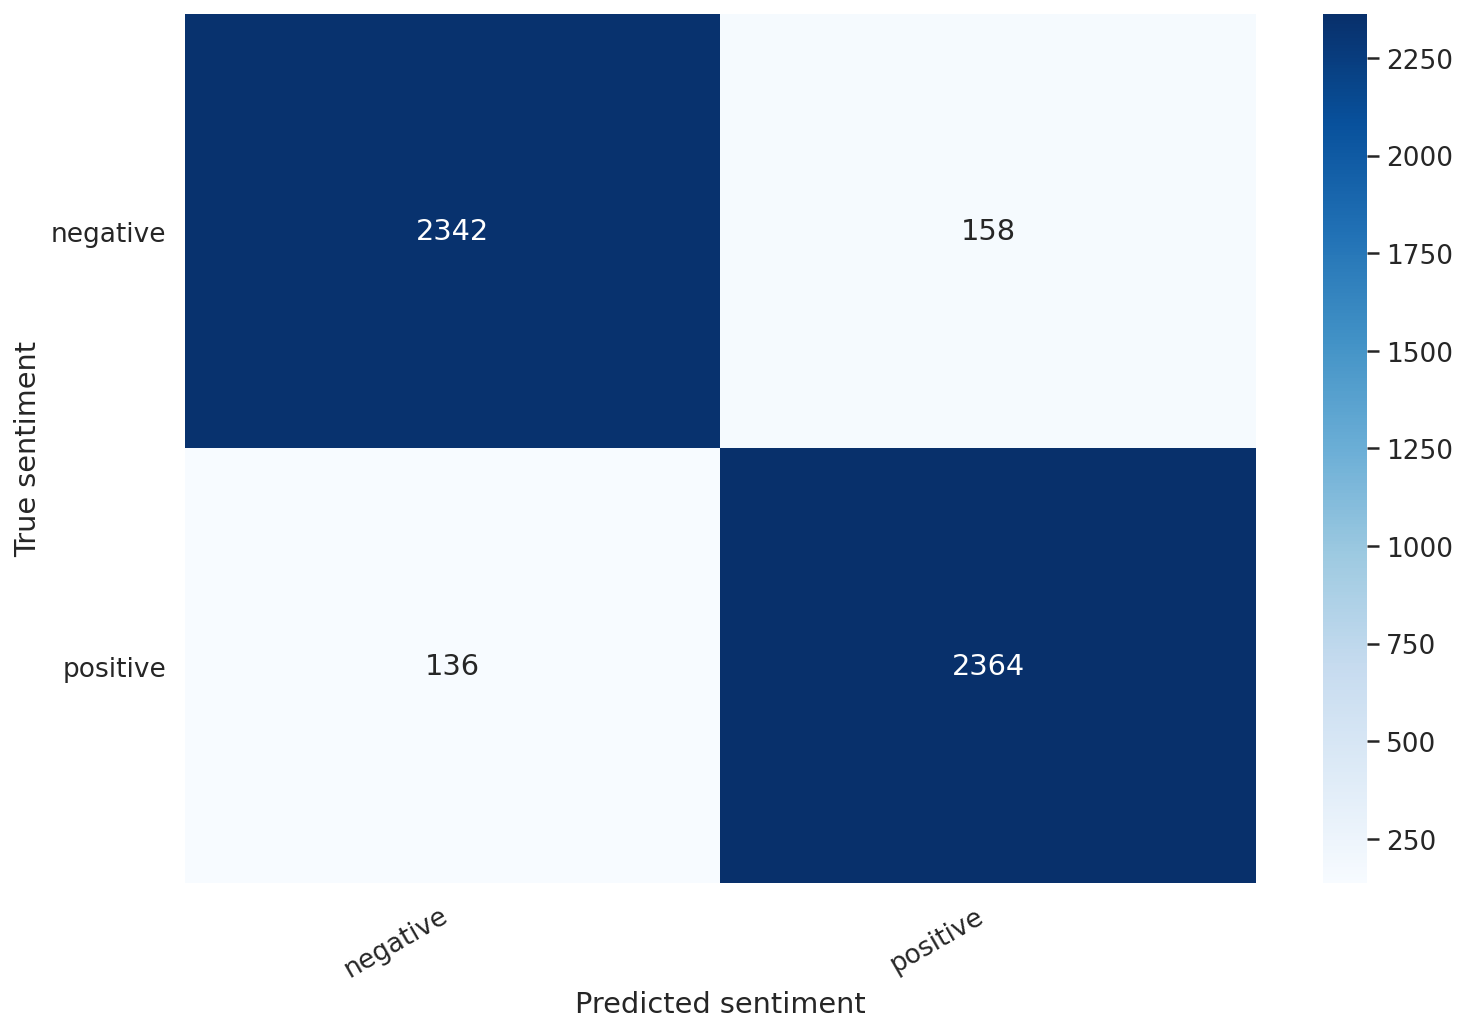

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(true_vals, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)